In [11]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd
import multiprocessing
from joblib import Parallel, delayed
num_cores = multiprocessing.cpu_count()
if num_cores == 32:
    num_cores = 24  # lsst-dev - don't use all the cores, man.
elif num_cores == 8:
    num_cores = 3
elif num_cores == 4:
    num_cores = 2
print num_cores

import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self, ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

pd.options.display.max_columns = 9999
pd.set_option('display.width', 9999)

import warnings
warnings.filterwarnings('ignore')

import diffimTests as dit

2


Note `avoidBorder=False` is slow, because stars near the border need to be rendered with care. But, `avoidBorder=True` messes up A&L, so we'll stick with `avoidBorder=False`.

{'ZOGY': {'FP': 2, 'FN': 30, 'TP': 20}, 'ALstack': {'FP': 4, 'FN': 33, 'TP': 17}, 'SZOGY': {'FP': 6, 'FN': 34, 'TP': 16}, 'ALstack_decorr': {'FP': 3, 'FN': 34, 'TP': 16}}


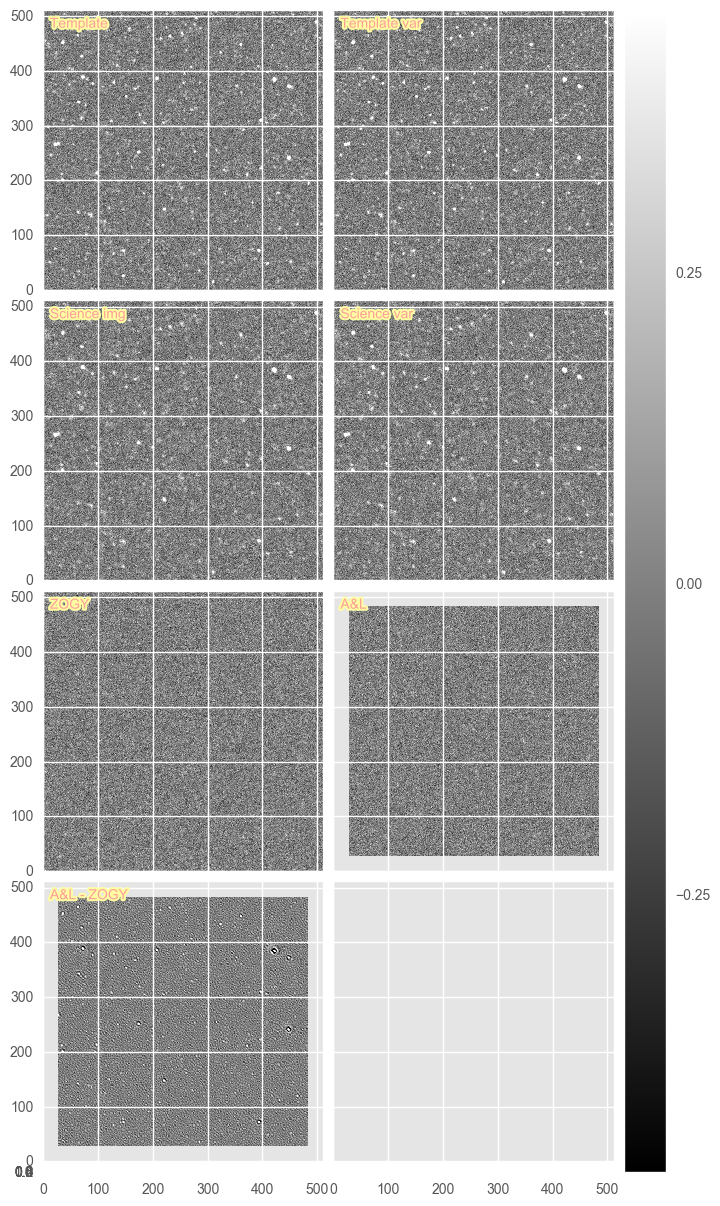

In [165]:
reload(dit);
testObj = dit.DiffimTest()
res = testObj.runTest()
print res
fig = plt.figure(1, (15, 15))
testObj.doPlot(nrows_ncols=(5, 2))

## Test out new options.

First, `templateNoNoise`.

{'ZOGY': {'FP': 4, 'FN': 20, 'TP': 30}, 'ALstack': {'FP': 2, 'FN': 23, 'TP': 27}, 'SZOGY': {'FP': 6, 'FN': 22, 'TP': 28}, 'ALstack_decorr': {'FP': 3, 'FN': 28, 'TP': 22}}


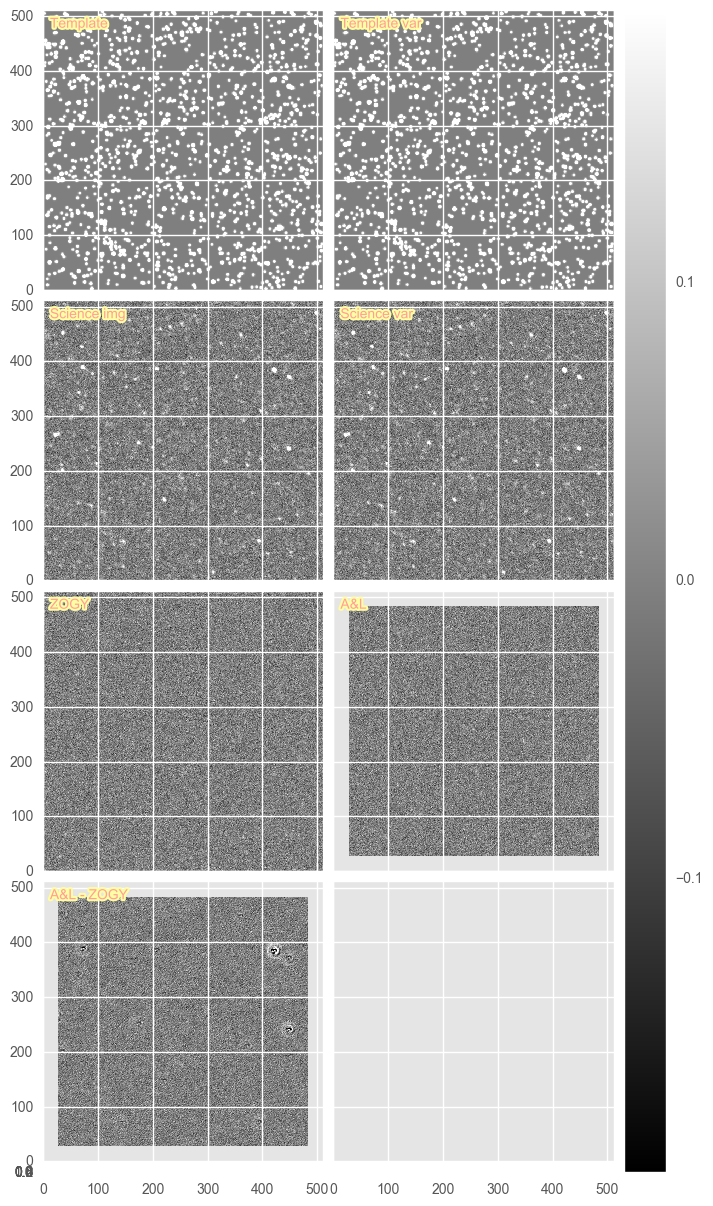

In [167]:
reload(dit);
testObj = dit.DiffimTest(templateNoNoise=True)
res = testObj.runTest()
print res
fig = plt.figure(1, (15, 15))
testObj.doPlot(nrows_ncols=(5, 2))

Next, `skyLimited`.

{'ZOGY': {'FP': 2, 'FN': 30, 'TP': 20}, 'ALstack': {'FP': 4, 'FN': 32, 'TP': 18}, 'SZOGY': {'FP': 5, 'FN': 32, 'TP': 18}, 'ALstack_decorr': {'FP': 3, 'FN': 34, 'TP': 16}}


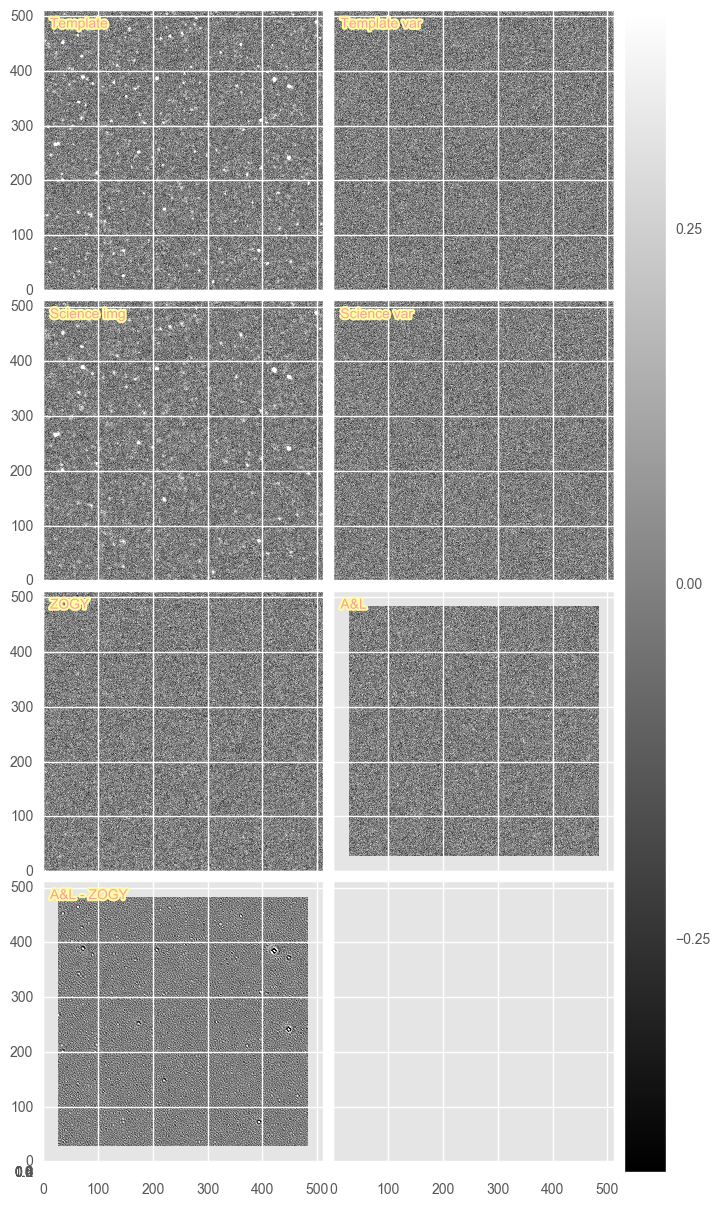

In [168]:
reload(dit);
testObj = dit.DiffimTest(skyLimited=True)
res = testObj.runTest()
print res
fig = plt.figure(1, (15, 15))
testObj.doPlot(nrows_ncols=(5, 2))

Try both...

{'ZOGY': {'FP': 4, 'FN': 20, 'TP': 30}, 'ALstack': {'FP': 1, 'FN': 22, 'TP': 28}, 'SZOGY': {'FP': 7, 'FN': 22, 'TP': 28}, 'ALstack_decorr': {'FP': 3, 'FN': 28, 'TP': 22}}
300.0 0.0


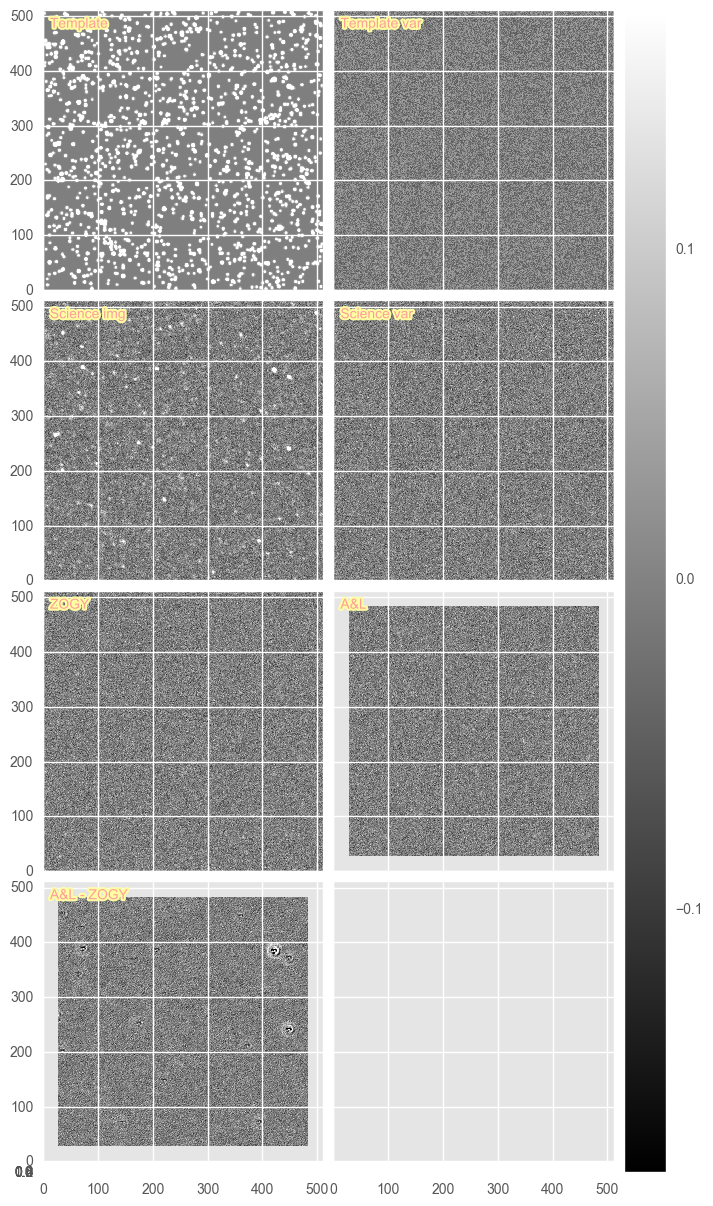

In [169]:
reload(dit);
testObj = dit.DiffimTest(templateNoNoise=True, skyLimited=True)
res = testObj.runTest()
print res
print np.mean(testObj.im1.var), np.std(testObj.im1.var)
testObj.im1.var += np.random.uniform(size=testObj.im1.var.shape)  # need to make it so we can plot it.
fig = plt.figure(1, (15, 15))
testObj.doPlot(nrows_ncols=(5, 2))

In [110]:
# Default 10 sources with same flux
def runTest(flux, seed=66, n_varSources=50):
    testObj = dit.DiffimTest(varFlux2=np.repeat(flux, n_varSources), seed=seed,
                            templateNoNoise=True, skyLimited=True)
    det = testObj.runTest()
    det['flux'] = flux
    return det

methods = ['ALstack', 'ZOGY', 'SZOGY', 'ALstack_decorr']

In [7]:
inputs = [(f, seed) for f in [750.] for seed in np.arange(66, 166, 1)]
print len(inputs)
testResults1 = Parallel(n_jobs=num_cores, verbose=2)(delayed(runTest)(i[0], i[1]) for i in inputs)

100


[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  7.1min
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed: 19.4min finished


In [ ]:
import cPickle, gzip
cPickle.dump((testResults1), gzip.GzipFile("30. 1. results.p.gz", "wb"))

In [124]:
def plotResults(tr, asHist=False, doPrint=True):
    FN = pd.DataFrame({key: np.array([t[key]['FN'] for t in tr]) for key in methods})
    FP = pd.DataFrame({key: np.array([t[key]['FP'] for t in tr]) for key in methods})
    TP = pd.DataFrame({key: np.array([t[key]['TP'] for t in tr]) for key in methods})
    if doPrint:
        print 'FN:', '\n', FN.mean()
        print 'FP:', '\n', FP.mean()
        print 'TP:', '\n', TP.mean()

    matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)
    fig, axes = plt.subplots(nrows=1, ncols=2)

    if not asHist:
        sns.violinplot(data=TP, cut=True, linewidth=0.3, bw=0.25, ax=axes[0])
        sns.swarmplot(data=TP, color='black', ax=axes[0])
        sns.boxplot(data=TP, saturation=0.5, ax=axes[0])
        axes[0].set_title('True positives')
        sns.violinplot(data=FP, cut=True, linewidth=0.3, bw=0.5, ax=axes[1])
        sns.swarmplot(data=FP, color='black', ax=axes[1])
        sns.boxplot(data=FP, saturation=0.5, ax=axes[1])
        axes[1].set_title('False positives')
    else:
        for t in TP:
            sns.distplot(TP[t], label=t, ax=axes[0])
        axes[0].set_title('True positives')
        legend = axes[0].legend(loc='upper left', shadow=True)
        for t in FP:
            sns.distplot(FP[t], label=t, ax=axes[1])
        axes[1].set_title('False positives')
        legend = axes[1].legend(loc='upper left', shadow=True)

FN: 
ALstack           15.58
ALstack_decorr    18.99
SZOGY             16.13
ZOGY              16.12
dtype: float64
FP: 
ALstack           6.32
ALstack_decorr    6.23
SZOGY             7.98
ZOGY              6.89
dtype: float64
TP: 
ALstack           34.37
ALstack_decorr    30.96
SZOGY             33.82
ZOGY              33.81
dtype: float64


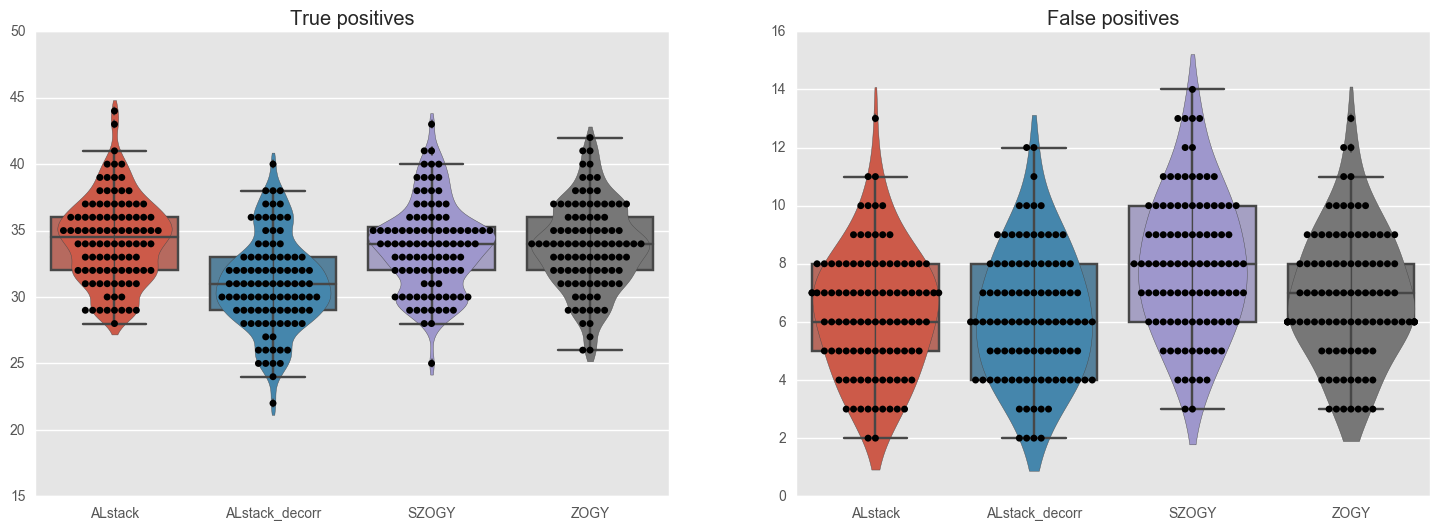

In [125]:
import cPickle, gzip
testResults1 = cPickle.load(gzip.GzipFile("30. 1. results.p.gz", "rb"))
plotResults(testResults1)

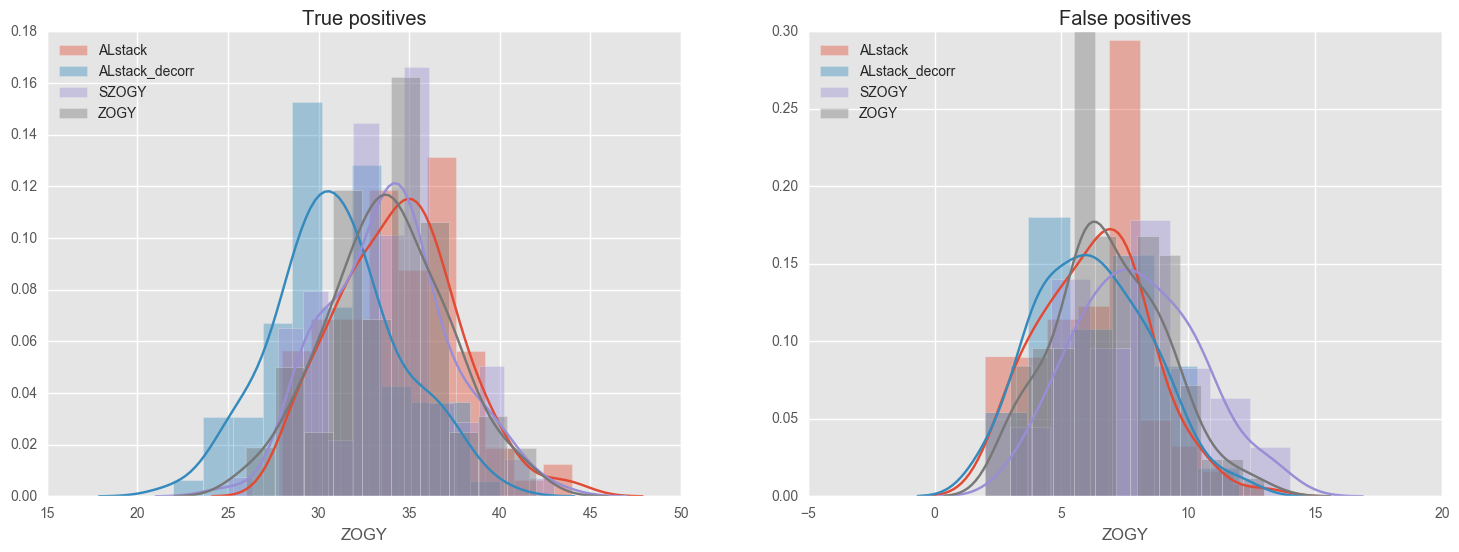

In [126]:
plotResults(testResults1, asHist=True, doPrint=False)